<a href="https://colab.research.google.com/github/FelixH44/git-collaboration-exercise/blob/master/Public_KielRegion_LSTM_performance_test(5with24hour)(scaled).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.0 Overview and Todos:

**Overview Notebook Strucutre:**


**ToDos:**

* Change targets into bikenumber difference instead of absolute bikenumber
*


- MinMaxScaling fit auf Xtrain+Targets (0-1 oder -1-1)


- Best model pick implementieren für alle (implementiert bsiher nur für lstm training loop)


- Dynamisches Ändern der lr (implementiert bsiher nur für lstm training loop)


## 0.1 Imports and Setup df

In [1]:
from google.colab import drive
import pandas as pd
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, ConcatDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Mount drive and setup sys path for mads_dl import
drive.mount('/content/drive')
sys.path.append('/content/drive/My Drive/')

# Importing mads_dl for access to metric functions
import mads_dl

# Replace 'path/to/your/file.csv' with the actual path to your CSV file in Google Drive
df = pd.read_csv('/content/drive/My Drive/FelixData_final_main_kiel.csv')

# Show if df s loaded right
df.head()

Mounted at /content/drive


,index,entityId,entityType,name,availableBikeNumber,freeSlotNumber,totalSlotNumber,pickups,dropoffs
0,2024-06-17T11:00:00.000+00:00,24367,BikeHireDockingStation,Anleger Dietrichsdorf,5.032787,25.000000,30.0,4627,4683
1,2024-06-17T12:00:00.000+00:00,24367,BikeHireDockingStation,Anleger Dietrichsdorf,6.762712,24.237288,30.0,4627,4683
2,2024-06-17T13:00:00.000+00:00,24367,BikeHireDockingStation,Anleger Dietrichsdorf,6.864407,24.000000,30.0,4627,4683
3,2024-06-17T14:00:00.000+00:00,24367,BikeHireDockingStation,Anleger Dietrichsdorf,5.846154,24.153846,30.0,4627,4683
4,2024-06-17T15:00:00.000+00:00,24367,BikeHireDockingStation,Anleger Dietrichsdorf,5.305556,24.694444,30.0,4627,4683


## 0.2 Data Engineering

Dataset adjustments that don't need to be done seperately for each entity_ID.

In [2]:
### Setting up day of year and time of day sin and cos ###
# Got this idea here: https://www.youtube.com/watch?v=kGdbPnMCdOg&t=1828s


# Convert 'index' to datetime
df['index'] = pd.to_datetime(df['index'])

# Extract seconds in day and calculate sine/cosine transformations
day = 24 * 60 * 60  # Total seconds in a day
year = 365.2425 * day  # Approximate total seconds in a year

# Ensure that all datetime objects are tz-naive (idk, had some error to prevent here)
df['index'] = df['index'].dt.tz_localize(None)

# Timestamp seconds (linear value for point in time)
df['Seconds'] = df['index'].map(pd.Timestamp.timestamp)

# Apply sine and cosine transformations
df['day_sin'] = np.sin(df['Seconds'] * (2* np.pi / day))
df['day_cos'] = np.cos(df['Seconds'] * (2 * np.pi / day))
df['year_sin'] = np.sin(df['Seconds'] * (2 * np.pi / year))
df['year_cos'] = np.cos(df['Seconds'] * (2 * np.pi / year))

# Drop temporary columns
df.drop(columns=['Seconds'], inplace=True)

# Year and day representation both not static (because its the same in YT example)
# Chat told me to keep year static, idk whats better (see comment)
df




,index,entityId,entityType,name,availableBikeNumber,freeSlotNumber,totalSlotNumber,pickups,dropoffs,day_sin,day_cos,year_sin,year_cos
0,2024-06-17 11:00:00,24367,BikeHireDockingStation,Anleger Dietrichsdorf,5.032787,25.000000,30.0,4627,4683,2.588190e-01,-0.965926,0.242824,-0.970070
1,2024-06-17 12:00:00,24367,BikeHireDockingStation,Anleger Dietrichsdorf,6.762712,24.237288,30.0,4627,4683,9.948840e-12,-1.000000,0.242128,-0.970244
2,2024-06-17 13:00:00,24367,BikeHireDockingStation,Anleger Dietrichsdorf,6.864407,24.000000,30.0,4627,4683,-2.588190e-01,-0.965926,0.241433,-0.970418
3,2024-06-17 14:00:00,24367,BikeHireDockingStation,Anleger Dietrichsdorf,5.846154,24.153846,30.0,4627,4683,-5.000000e-01,-0.866025,0.240737,-0.970590
4,2024-06-17 15:00:00,24367,BikeHireDockingStation,Anleger Dietrichsdorf,5.305556,24.694444,30.0,4627,4683,-7.071068e-01,-0.707107,0.240042,-0.970763
...,...,...,...,...,...,...,...,...,...,...,...,...,...
86496,2024-09-30 19:00:00,26889,BikeHireDockingStation,Wilhelmplatz,1.066667,28.833333,30.0,14328,14285,-9.659258e-01,0.258819,-0.999992,-0.004046
86497,2024-09-30 20:00:00,26889,BikeHireDockingStation,Wilhelmplatz,0.000000,30.000000,30.0,14328,14285,-8.660254e-01,0.500000,-0.999994,-0.003329
86498,2024-09-30 21:00:00,26889,BikeHireDockingStation,Wilhelmplatz,0.000000,30.000000,30.0,14328,14285,-7.071068e-01,0.707107,-0.999997,-0.002613
86499,2024-09-30 22:00:00,26889,BikeHireDockingStation,Wilhelmplatz,0.000000,30.000000,30.0,14328,14285,-5.000000e-01,0.866025,-0.999998,-0.001896


## 0.3 Hyperparameters for Dataset reation and training
Adjusting these parameters will influence what kind of dataset the models will train on.

**lookback_lag:** How big is the time window into the past per data instance.<br>
**target_shift:** How much hours into the future should the predicted target be.
<br>
**entity_ids:** Which entities should our models be working with.

In [3]:
# How large is the time window into the past for each prediction (hours)
lookback_lag = 24

# How many hours into future are we trying to predict
target_shift = -5

# Which station IDs are we working with
entity_ids = [24397, 24367, 24370]

# 1.0 Dataset creation:
Dynamically create datasets for training/testing based on hyperparamter entity_ids.

ToDos:

* Insert weatherdata
* Setup function for combined datasets so that the station_ID value is in the data for every timestep
* Get Data for all stations, not just kiel

## 1.1 Setup Dataset Class and Device

In [4]:
### Setting up Dataset class to store data for each Entity in ###

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [8]:
### setup device if we want to train on cuda (currently not compatible with mads_dl) ###

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 1.2 Dataset creation per EntityID

In [5]:
### Function to create datasets per entityID (scaled)###

def create_datasets_for_entity(df, entity_id, lookback_lag, target_shift):
    print(f"\nProcessing entity ID: {entity_id}")

    # Filter the DataFrame for the given entityId
    df_entity = df.loc[df['entityId'] == entity_id].reset_index(drop=True)
    print(f"Initial rows for entity {entity_id}: {len(df_entity)}")

    # Check if ID is valid
    if df_entity.empty:
        print(f"  Warning: No data found for entity {entity_id}. Skipping...")
        return None, None, None, None

    # Convert 'index' to datetime (I outsourced this to 0.2)
    df_entity['index'] = pd.to_datetime(df_entity['index'])

    # Select relevant columns and create a copy to avoid SettingWithCopyWarning
    df_entity_model = df_entity[['index', 'availableBikeNumber', 'day_sin', 'day_cos', 'year_sin', 'year_cos']].copy()

    # Create targets (shifted values)
    df_entity_model['targets'] = df_entity_model['availableBikeNumber'].shift(target_shift-(lookback_lag+target_shift)) # corrected target shift logic for updated sliding window approach

    # Drop rows with NaN values created by the shift
    df_entity_model.dropna(inplace=True)

    # Initialize scalers
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))

    # Convert DataFrame to numpy arrays
    data = df_entity_model[['availableBikeNumber', 'day_sin', 'day_cos', 'year_sin', 'year_cos']].to_numpy().astype(np.float32)
    targets = df_entity_model['targets'].to_numpy().astype(np.float32).reshape(-1, 1)

    # Fit the scalers on training data only to prevent data leakage
    train_idx = int(len(data) * 0.8)
    scaler_X.fit(data[:train_idx])
    scaler_y.fit(targets[:train_idx])

    # Scale the data
    data_scaled = scaler_X.transform(data)
    targets_scaled = scaler_y.transform(targets)

    # Create sequences for X and y using sliding window
    X_sequences = []
    y_sequences = []

    # Iterate over
    for i in range(len(data_scaled) - lookback_lag):
        X_sequences.append(data_scaled[i:i + lookback_lag])  # 48 time steps of 5 features
        y_sequences.append(targets_scaled[i]) # took + lookback_lag out

    # Convert to numpy arrays
    X_sequences = np.array(X_sequences)
    y_sequences = np.array(y_sequences)

    # Split into training and testing datasets (80% train, 20% test)
    train_size = int(len(X_sequences) * 0.8)

    X_train = X_sequences[:train_size]
    X_test = X_sequences[train_size:]
    y_train = y_sequences[:train_size]
    y_test = y_sequences[train_size:]

    print(f"  Feature dimension: {data.shape[1]}")
    print(f"  X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"  X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    return TimeSeriesDataset(X_train, y_train), TimeSeriesDataset(X_test, y_test), scaler_X, scaler_y

In [6]:
### Function to create datasets per entityID (unscaled for testing/inspecting reasons) ###

def create_datasets_for_entity_unscaled(df, entity_id, lookback_lag, target_shift):
    print(f"\nProcessing entity ID: {entity_id}")

    # Filter the DataFrame for the given entityId
    df_entity = df.loc[df['entityId'] == entity_id].reset_index(drop=True)
    print(f"Initial rows for entity {entity_id}: {len(df_entity)}")

    # Check if ID is valid
    if df_entity.empty:
        print(f"  Warning: No data found for entity {entity_id}. Skipping...")
        return None, None, None, None

    # Convert 'index' to datetime
    df_entity['index'] = pd.to_datetime(df_entity['index'])

    # Select relevant columns and create a copy to avoid SettingWithCopyWarning
    df_entity_model = df_entity[['index', 'availableBikeNumber', 'day_sin', 'day_cos', 'year_sin', 'year_cos']].copy()

    # Create targets (shifted values)
    df_entity_model['targets'] = df_entity_model['availableBikeNumber'].shift(target_shift-(lookback_lag+target_shift)) # corrected target shift logic for updated sliding window approach

    # Drop rows with NaN values created by the shift
    df_entity_model.dropna(inplace=True)

    # Convert DataFrame to numpy arrays
    data = df_entity_model[['availableBikeNumber', 'day_sin', 'day_cos', 'year_sin', 'year_cos']].to_numpy().astype(np.float32)
    targets = df_entity_model['targets'].to_numpy().astype(np.float32).reshape(-1, 1)

    # Create sequences for X and y using sliding window
    X_sequences = []
    y_sequences = []

    for i in range(len(data) - lookback_lag):
        X_sequences.append(data[i:i + lookback_lag])  # 10 time steps of 5 features
        y_sequences.append(targets[i]) # took the addition of lookback_lag out (produced t)

    # Convert to numpy arrays
    X_sequences = np.array(X_sequences)
    y_sequences = np.array(y_sequences)

    # Split into training and testing datasets (80% train, 20% test)
    train_size = int(len(X_sequences) * 0.8)

    X_train = X_sequences[:train_size]
    X_test = X_sequences[train_size:]
    y_train = y_sequences[:train_size]
    y_test = y_sequences[train_size:]

    print(f"  Feature dimension: {data.shape[1]}")
    print(f"  X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"  X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    return TimeSeriesDataset(X_train, y_train), TimeSeriesDataset(X_test, y_test)


## 1.3 Inspect unshuffled, unscaled dataset batches and check with original df if needed

In [9]:
# Create batch size
batch_size = 16

# Dictionary to store train and test DataLoaders for each entity
dataloaders = {}

# Loop through the list of entity IDs to create DataLoaders
for entity_id in entity_ids:

    # Create Datasets
    train_dataset, test_dataset = create_datasets_for_entity_unscaled(df, entity_id, lookback_lag, target_shift)

    # If the datasets are not None, create DataLoaders
    if train_dataset is not None and test_dataset is not None:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Store the loaders in the dictionary
        dataloaders[entity_id] = {
            "train_loader": train_loader,
            "test_loader": test_loader,
        }

        print(f"DataLoaders created for entity ID {entity_id}: "
              f"Train Loader batches: {len(train_loader)}, "
              f"Test Loader batches: {len(test_loader)}")
    else:
        print(f"Skipped entity ID {entity_id} due to insufficient data.")

### inspect one batch for every dataset (unscaled) ###

for entity_id, loaders in dataloaders.items():
    train_loader = loaders["train_loader"]
    test_loader = loaders["test_loader"]

    # Inspect the first batch from the train_loader
    for _, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        print(f"Entity ID {entity_id} - Train Data:")
        print("x_batch shape:", x_batch.shape)
        print("y_batch shape:", y_batch.shape)

        # Print the first few rows of x_batch and y_batch (up to lookback_lag is capped by batch size (16 currently))
        print("First few rows of x_batch:", x_batch[0:lookback_lag].cpu().numpy())  # Convert to NumPy for better readability
        print("First few rows of y_batch:", y_batch[0:lookback_lag].cpu().numpy())
        print("-" * 30)
        break  # Stop after the first batch to just inspect one

    # Inspect the first batch from the test_loader
    for _, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        print(f"Entity ID {entity_id} - Test Data:")
        print("x_batch shape:", x_batch.shape)
        print("y_batch shape:", y_batch.shape)

        # Print the first few rows of x_batch and y_batch
        print("First few rows of x_batch:", x_batch[0:lookback_lag].cpu().numpy())  # Convert to NumPy for better readability
        print("First few rows of y_batch:", y_batch[0:lookback_lag].cpu().numpy())
        print("-" * 30)
        break  # Stop after the first batch to just inspect one




Processing entity ID: 24397
Initial rows for entity 24397: 2412
  Feature dimension: 5
  X_train shape: (1891, 24, 5), y_train shape: (1891, 1)
  X_test shape: (473, 24, 5), y_test shape: (473, 1)
DataLoaders created for entity ID 24397: Train Loader batches: 119, Test Loader batches: 30

Processing entity ID: 24367
Initial rows for entity 24367: 2411
  Feature dimension: 5
  X_train shape: (1890, 24, 5), y_train shape: (1890, 1)
  X_test shape: (473, 24, 5), y_test shape: (473, 1)
DataLoaders created for entity ID 24367: Train Loader batches: 119, Test Loader batches: 30

Processing entity ID: 24370
Initial rows for entity 24370: 2413
  Feature dimension: 5
  X_train shape: (1892, 24, 5), y_train shape: (1892, 1)
  X_test shape: (473, 24, 5), y_test shape: (473, 1)
DataLoaders created for entity ID 24370: Train Loader batches: 119, Test Loader batches: 30
Entity ID 24397 - Train Data:
x_batch shape: torch.Size([16, 24, 5])
y_batch shape: torch.Size([16, 1])
First few rows of x_batch:

## 1.4 Create Train/Test loaders for model training

Dynamically creating train/test loaders for all entries in entity_ids hyperparameter. Create one combined train/test loader containing all entity_ids entries combined. Then stored in dictionary with scalers for inverting scaling transformation.

In [10]:
# Setting size for dataloader batches
batch_size = 16

# Dictionary to store train and test DataLoaders for each entity
dataloaders = {}

# Lists to hold combined datasets
all_train_datasets = []
all_test_datasets = []

# Loop through the list of entity IDs to create DataLoaders
for entity_id in entity_ids:
    # Create Datasets and obtain scalers
    train_dataset, test_dataset, scaler_X, scaler_y = create_datasets_for_entity(df, entity_id, lookback_lag, target_shift)

    # If the datasets are not None, create DataLoaders
    if train_dataset is not None and test_dataset is not None:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) #
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Store the loaders and scalers in the dictionary
        dataloaders[entity_id] = {
            "train_loader": train_loader,
            "test_loader": test_loader,
            "scaler_X": scaler_X,  # Store the input scaler
            "scaler_y": scaler_y   # Store the target scaler
        }

        # Append datasets to the combined lists
        all_train_datasets.append(train_dataset)
        all_test_datasets.append(test_dataset)

        print(f"DataLoaders created for entity ID {entity_id}: "
              f"Train Loader batches: {len(train_loader)}, "
              f"Test Loader batches: {len(test_loader)}")
    else:
        print(f"Skipped entity ID {entity_id} due to insufficient data.")

# Create combined datasets
if all_train_datasets:
    combined_train_dataset = ConcatDataset(all_train_datasets)
    combined_test_dataset = ConcatDataset(all_test_datasets)

    # Create combined DataLoaders
    combined_train_loader = DataLoader(combined_train_dataset, batch_size=batch_size, shuffle=True)
    combined_test_loader = DataLoader(combined_test_dataset, batch_size=batch_size, shuffle=False)

    print(f"Combined DataLoader created: "
          f"Train Loader batches: {len(combined_train_loader)}, "
          f"Test Loader batches: {len(combined_test_loader)}")
else:
    print("No valid training datasets available for combination.")

# Example: Access individual entity DataLoaders
train_loader_entity_24367 = dataloaders[24367]["train_loader"]
test_loader_entity_24367 = dataloaders[24367]["test_loader"]

# Example: Accessing scalers for inverse transformation
scaler_X_24367 = dataloaders[24367]["scaler_X"]
scaler_y_24367 = dataloaders[24367]["scaler_y"]


Processing entity ID: 24397
Initial rows for entity 24397: 2412
  Feature dimension: 5
  X_train shape: (1891, 24, 5), y_train shape: (1891, 1)
  X_test shape: (473, 24, 5), y_test shape: (473, 1)
DataLoaders created for entity ID 24397: Train Loader batches: 119, Test Loader batches: 30

Processing entity ID: 24367
Initial rows for entity 24367: 2411
  Feature dimension: 5
  X_train shape: (1890, 24, 5), y_train shape: (1890, 1)
  X_test shape: (473, 24, 5), y_test shape: (473, 1)
DataLoaders created for entity ID 24367: Train Loader batches: 119, Test Loader batches: 30

Processing entity ID: 24370
Initial rows for entity 24370: 2413
  Feature dimension: 5
  X_train shape: (1892, 24, 5), y_train shape: (1892, 1)
  X_test shape: (473, 24, 5), y_test shape: (473, 1)
DataLoaders created for entity ID 24370: Train Loader batches: 119, Test Loader batches: 30
Combined DataLoader created: Train Loader batches: 355, Test Loader batches: 89


In [12]:
### Access batches to check data shapes again ###

for entity_id, loaders in dataloaders.items():
    train_loader = loaders["train_loader"]

    # Get the first batch from the train_loader
    for _, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        print(f"Entity ID {entity_id}:")
        print("x_batch shape:", x_batch.shape)
        print("y_batch shape:", y_batch.shape)
        print("-" * 30)
        break  # Stop after the first batch to just inspect one


Entity ID 24397:
x_batch shape: torch.Size([16, 24, 5])
y_batch shape: torch.Size([16, 1])
------------------------------
Entity ID 24367:
x_batch shape: torch.Size([16, 24, 5])
y_batch shape: torch.Size([16, 1])
------------------------------
Entity ID 24370:
x_batch shape: torch.Size([16, 24, 5])
y_batch shape: torch.Size([16, 1])
------------------------------


# 2.0 Setting up models (LSTM, TCN, CNN/LSTM-hybrid):

If our model fleet gets expanded additional training loops (3.) are needed and the metrics/visualization code needs to be adjusted as it is fixed right now on these models.

**ToDo:**

* Study and document model functionalities
* Optimize hyperparameters

## 2.1 LSTM Setup:

In [13]:
### Classic LSTM setup ###

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


## 2.2 TCN Setup:

Stacking multiple temporal blocks.

In [14]:
class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.batchnorm1 = nn.BatchNorm1d(out_channels)  # Add BatchNorm
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.batchnorm2 = nn.BatchNorm1d(out_channels)  # Add BatchNorm
        self.dropout2 = nn.Dropout(dropout)
        self.net = nn.Sequential(
            self.conv1, nn.ReLU(), self.batchnorm1, self.dropout1,
            self.conv2, nn.ReLU(), self.batchnorm2, self.dropout2
        )
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        if out.size(2) != x.size(2):
            diff = x.size(2) - out.size(2)
            out = F.pad(out, (0, diff))
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size=2, num_layers=3, dropout=0.2):
        super(TCN, self).__init__()
        layers = []
        for i in range(num_layers):
            dilation = 2 ** i
            in_channels = input_channels if i == 0 else hidden_channels
            out_channels = hidden_channels
            layers.append(TemporalBlock(in_channels, out_channels, kernel_size, stride=1,
                                        dilation=dilation, padding=(kernel_size-1) * dilation, dropout=dropout))
        self.network = nn.Sequential(*layers)
        self.fc = nn.Linear(hidden_channels, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Permute to (batch_size, input_channels, sequence_length)
        x = self.network(x)
        x = x[:, :, -1]  # Take the last output
        x = self.fc(x)
        return x


## 2.3 CNN/LSTM Setup:

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_LSTM(nn.Module):
    def __init__(self, input_size, cnn_out_channels, kernel_size, lstm_hidden_size, lstm_layers):
        super(CNN_LSTM, self).__init__()
        self.cnn = nn.Conv1d(in_channels=input_size, out_channels=cnn_out_channels, kernel_size=kernel_size)
        self.lstm = nn.LSTM(input_size=cnn_out_channels, hidden_size=lstm_hidden_size,
                            num_layers=lstm_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_size, 1)

    def forward(self, x):
        # CNN layer
        x = x.permute(0, 2, 1)  # Convert to (batch, channels, sequence_length)
        x = F.relu(self.cnn(x))
        x = x.permute(0, 2, 1)  # Back to (batch, sequence_length, channels)

        # LSTM layer
        out, _ = self.lstm(x)

        # Fully connected layer on the last LSTM output
        out = self.fc(out[:, -1, :])
        return out


## 2.4 Deploying model instances into a model dictionary
* Setting up fixed hyperparamters for each model type
* Store model instances for each type (2.1 - 2.3) for every entry in entity_ids
* Store additional model instances (combined models) for training on station unspecific data (combined datasets)

In [16]:
# Define a dictionary to hold all models
models = {
    "per_entity": {},
    "combined": {}
}

# Hyperparameters LSTM
lstm_input_size = 5 # set to number of features used for learning
lstm_hidden_size = 8
lstm_num_layers = 2

# Hyperparameters TCN
tcn_input_channels = lookback_lag # I'm lost with TCNs and tend to argue with Chat about this stuff. Keeping it at lookback_lag works out though
tcn_hidden_channels = 16

# Hyperparameters CNN/LSTM
cnn_lstm_input_size = 5 # set to number of features used for learning
cnn_out_channels = 16
kernel_size = 3
lstm_hidden_size = 8
lstm_layers = 2

# Create models for each entity
for entity_id in dataloaders.keys():
    # LSTM
    lstm_model = LSTM(lstm_input_size, lstm_hidden_size, lstm_num_layers).to(device)

    # TCN
    tcn_model = TCN(input_channels=tcn_input_channels, hidden_channels=tcn_hidden_channels).to(device)

    # CNN-LSTM
    cnn_lstm_model = CNN_LSTM(cnn_lstm_input_size, cnn_out_channels, kernel_size, lstm_hidden_size, lstm_layers).to(device)

    # Store the models in the dictionary
    models["per_entity"][entity_id] = {
        "LSTM": lstm_model,
        "TCN": tcn_model,
        "CNN_LSTM": cnn_lstm_model
    }

# Create models for combined datasets
combined_lstm_model = LSTM(lstm_input_size, lstm_hidden_size, lstm_num_layers).to(device)
combined_tcn_model = TCN(input_channels=tcn_input_channels, hidden_channels=tcn_hidden_channels).to(device)
combined_cnn_lstm_model = CNN_LSTM(cnn_lstm_input_size, cnn_out_channels, kernel_size, lstm_hidden_size, lstm_layers).to(device)

# Store combined models in the dictionary
models["combined"]["LSTM"] = combined_lstm_model
models["combined"]["TCN"] = combined_tcn_model
models["combined"]["CNN_LSTM"] = combined_cnn_lstm_model

# Verifying the setup
for entity_id, entity_models in models["per_entity"].items():
    print(f"Entity ID {entity_id}:")
    for model_name, model in entity_models.items():
        print(f"  {model_name}: {model}")
    print("-" * 40)

print("Combined Models:")
for model_name, model in models["combined"].items():
    print(f"  {model_name}: {model}")


Entity ID 24397:
  LSTM: LSTM(
  (lstm): LSTM(5, 8, num_layers=2, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)
  TCN: TCN(
  (network): Sequential(
    (0): TemporalBlock(
      (conv1): Conv1d(24, 16, kernel_size=(2,), stride=(1,), padding=(1,))
      (batchnorm1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout1): Dropout(p=0.2, inplace=False)
      (conv2): Conv1d(16, 16, kernel_size=(2,), stride=(1,), padding=(1,))
      (batchnorm2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout2): Dropout(p=0.2, inplace=False)
      (net): Sequential(
        (0): Conv1d(24, 16, kernel_size=(2,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout(p=0.2, inplace=False)
        (4): Conv1d(16, 16, kernel_size=(2,), stride=(1,), padding=(1,))
        (5): ReLU()
   

# 3.0 Model Training:

## 3.1 Training (Classic LSTM)

In [18]:
### Setup functions for training/evaluation epochs ###

def train_one_epoch_lstm(model, train_loader, optimizer, loss_function, epoch, num_epochs, y_train_predictions):
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # Get model predictions
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        # Save predictions for the last epoch
        if epoch == (num_epochs - 1):  # Assuming 'epoch' and 'num_epochs' are defined
            y_train_predictions.append(output.cpu().detach().numpy())

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index + 1, avg_loss_across_batches))
            running_loss = 0.0
    print()


def validate_one_epoch_lstm(model, test_loader, loss_function):
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

    return avg_loss_across_batches  # Added return statement

### Define hyperparameters for LSTM (I actually took the same for CNN_LSTM)
learning_rate = 0.001
num_epochs = 50
loss_function = nn.MSELoss()


In [19]:
### Training loop: Training LSTM models for each entity dataset and the combined LSTM model with data across all stations ###

print("Training LSTM Models for Each Entity")
for entity_id, entity_loaders in dataloaders.items():
    # Access the specific LSTM model
    lstm_model = models["per_entity"][entity_id]["LSTM"]
    # Define a separate optimizer for each model
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)

    # Define learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=30, verbose=True)

    best_loss = float('inf')
    best_weights = None
    y_train_predictions = []  # Reset predictions list for each entity

    print(f"\nTraining LSTM for Entity ID: {entity_id}")

    # Train for the specified number of epochs
    for epoch in range(num_epochs):
        train_one_epoch_lstm(lstm_model, entity_loaders["train_loader"], optimizer, loss_function, epoch, num_epochs, y_train_predictions)

        # Validation
        val_loss = validate_one_epoch_lstm(lstm_model, entity_loaders["test_loader"], loss_function)

        # Save the best weights if the current validation loss is lower
        if val_loss < best_loss:
            best_loss = val_loss
            best_weights = lstm_model.state_dict().copy()

        # Adjust learning rate based on validation loss
        scheduler.step(val_loss)

    # Load the best weights after training is complete
    lstm_model.load_state_dict(best_weights)

    # Convert predictions to NumPy if needed
    y_train_predictions = np.concatenate(y_train_predictions).flatten()

# Training combined LSTM model
print("Training Combined LSTM Model")
combined_lstm_model = models["combined"]["LSTM"]
combined_optimizer = torch.optim.Adam(combined_lstm_model.parameters(), lr=learning_rate)

# Define learning rate scheduler for combined model
combined_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(combined_optimizer, mode='min', factor=0.1, patience=5, verbose=True)

best_combined_loss = float('inf')
best_combined_weights = None
y_train_predictions_combined = []

# Train combined model
for epoch in range(num_epochs):
    train_one_epoch_lstm(combined_lstm_model, combined_train_loader, combined_optimizer, loss_function, epoch, num_epochs, y_train_predictions_combined)

    # Validation
    val_combined_loss = validate_one_epoch_lstm(combined_lstm_model, combined_test_loader, loss_function)

    # Save the best weights if the current validation loss is lower
    if val_combined_loss < best_combined_loss:
        best_combined_loss = val_combined_loss
        best_combined_weights = combined_lstm_model.state_dict().copy()

    # Adjust learning rate based on validation loss
    combined_scheduler.step(val_combined_loss)

# Load the best weights after training is complete
combined_lstm_model.load_state_dict(best_combined_weights)

# After training, convert combined predictions to a NumPy array if needed
y_train_predictions_combined = np.concatenate(y_train_predictions_combined).flatten()


Training LSTM Models for Each Entity


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Training LSTM for Entity ID: 24397
Epoch: 1
Batch 100, Loss: 0.037

Val Loss: 0.029
***************************************************

Epoch: 2
Batch 100, Loss: 0.018

Val Loss: 0.037
***************************************************

Epoch: 3
Batch 100, Loss: 0.012

Val Loss: 0.023
***************************************************

Epoch: 4
Batch 100, Loss: 0.009

Val Loss: 0.019
***************************************************

Epoch: 5
Batch 100, Loss: 0.007

Val Loss: 0.017
***************************************************

Epoch: 6
Batch 100, Loss: 0.006

Val Loss: 0.012
***************************************************

Epoch: 7
Batch 100, Loss: 0.005

Val Loss: 0.010
***************************************************

Epoch: 8
Batch 100, Loss: 0.004

Val Loss: 0.006
***************************************************

Epoch: 9
Batch 100, Loss: 0.004

Val Loss: 0.005
***************************************************

Epoch: 10
Batch 100, Loss: 0.003

Val Loss: 0.

## 3.2 Training (CNN_LSTM)

**ToDo:**

* Training Loop: lr variability (lr_scheduler), save best weights -> load best weights after training

In [20]:
### Define the training and validation functions for CNN-LSTM ###

def train_one_epoch_cnn_lstm(model, train_loader, optimizer, loss_function, epoch, num_epochs, y_train_predictions):
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # Get model predictions
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        # Save predictions for the last epoch
        if epoch == (num_epochs - 1):
            y_train_predictions.append(output.cpu().detach().numpy())

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index + 1, avg_loss_across_batches))
            running_loss = 0.0
    print()


def validate_one_epoch_cnn_lstm(model, test_loader, loss_function):
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()



In [21]:
### Training all CNN-LSTM models for each entity dataset and one combined model on cross station data ###

print("Training CNN-LSTM Models for Each Entity")
for entity_id, entity_loaders in dataloaders.items():
    # Access the specific CNN-LSTM model
    cnn_lstm_model = models["per_entity"][entity_id]["CNN_LSTM"]
    # Define a separate optimizer for each model
    optimizer = torch.optim.Adam(cnn_lstm_model.parameters(), lr=learning_rate)

    y_train_predictions = []  # Reset predictions list for each entity
    print(f"\nTraining CNN-LSTM for Entity ID: {entity_id}")

    # Train for the specified number of epochs
    for epoch in range(num_epochs):
        train_one_epoch_cnn_lstm(cnn_lstm_model, entity_loaders["train_loader"], optimizer, loss_function, epoch, num_epochs, y_train_predictions)
        validate_one_epoch_cnn_lstm(cnn_lstm_model, entity_loaders["test_loader"], loss_function)

    # Convert predictions to NumPy if needed
    y_train_predictions = np.concatenate(y_train_predictions).flatten()

# Training combined CNN-LSTM model
print("Training Combined CNN-LSTM Model")
combined_cnn_lstm_model = models["combined"]["CNN_LSTM"]
combined_optimizer = torch.optim.Adam(combined_cnn_lstm_model.parameters(), lr=learning_rate)

y_train_predictions_combined = []

# Train combined model
for epoch in range(num_epochs):
    train_one_epoch_cnn_lstm(combined_cnn_lstm_model, combined_train_loader, combined_optimizer, loss_function, epoch, num_epochs, y_train_predictions_combined)
    validate_one_epoch_cnn_lstm(combined_cnn_lstm_model, combined_test_loader, loss_function)

# After training, convert combined predictions to a NumPy array if needed
y_train_predictions_combined = np.concatenate(y_train_predictions_combined).flatten()


Training CNN-LSTM Models for Each Entity

Training CNN-LSTM for Entity ID: 24397
Epoch: 1
Batch 100, Loss: 0.058

Val Loss: 0.045
***************************************************

Epoch: 2
Batch 100, Loss: 0.029

Val Loss: 0.026
***************************************************

Epoch: 3
Batch 100, Loss: 0.012

Val Loss: 0.020
***************************************************

Epoch: 4
Batch 100, Loss: 0.009

Val Loss: 0.017
***************************************************

Epoch: 5
Batch 100, Loss: 0.008

Val Loss: 0.015
***************************************************

Epoch: 6
Batch 100, Loss: 0.006

Val Loss: 0.009
***************************************************

Epoch: 7
Batch 100, Loss: 0.005

Val Loss: 0.008
***************************************************

Epoch: 8
Batch 100, Loss: 0.004

Val Loss: 0.005
***************************************************

Epoch: 9
Batch 100, Loss: 0.003

Val Loss: 0.006
***************************************************

E

## 3.3 Training (TCN):

**ToDo:**
* Training Loop: lr variability (lr_scheduler), save best weights -> load best weights after training

In [22]:
learning_rate_tcn = 0.0001
num_epochs_tcn = 75
loss_function_tcn = nn.MSELoss()

In [23]:
### Define the training and validation functions for TCN ###

def train_one_epoch_tcn(model, train_loader, optimizer, loss_function, epoch, num_epochs, y_train_predictions):
    model.train(True)
    running_loss = 0.0
    print(f'Epoch: {epoch + 1}')

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # Reshape the input for TCN
        x_batch = x_batch.permute(0, 2, 1)  # Convert to (batch_size, input_features, sequence_length)

        # Get model predictions
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        # Save predictions for the last epoch
        if epoch == (num_epochs - 1):
            y_train_predictions.append(output.cpu().detach().numpy())

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print(f'TCN - Batch {batch_index + 1}, Loss: {avg_loss_across_batches:.3f}')
            running_loss = 0.0
    print()


def validate_one_epoch_tcn(model, test_loader, loss_function):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for batch_index, batch in enumerate(test_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)

            # Reshape the input for TCN
            x_batch = x_batch.permute(0, 2, 1)  # Convert to (batch_size, input_features, sequence_length)

            # Get predictions
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    print(f'TCN - Val Loss: {avg_loss_across_batches:.3f}')
    print('***************************************************\n')

In [24]:
### Training all TCN models for each entity dataset and combined model on cross station data ###

print("Training TCN Models for Each Entity")
for entity_id, entity_loaders in dataloaders.items():
    # Access the specific TCN model
    tcn_model = models["per_entity"][entity_id]["TCN"]
    # Define a separate optimizer for each model
    optimizer = torch.optim.Adam(tcn_model.parameters(), lr=learning_rate_tcn)

    y_train_predictions = []  # Reset predictions list for each entity
    print(f"\nTraining TCN for Entity ID: {entity_id}")

    # Train for the specified number of epochs
    for epoch in range(num_epochs_tcn):
        train_one_epoch_tcn(tcn_model, entity_loaders["train_loader"], optimizer, loss_function_tcn, epoch, num_epochs_tcn, y_train_predictions)
        validate_one_epoch_tcn(tcn_model, entity_loaders["test_loader"], loss_function_tcn)

    # Convert predictions to NumPy if needed
    y_train_predictions = np.concatenate(y_train_predictions).flatten()

# Training combined TCN model
print("Training Combined TCN Model")
combined_tcn_model = models["combined"]["TCN"]
combined_optimizer = torch.optim.Adam(combined_tcn_model.parameters(), lr=learning_rate_tcn)

y_train_predictions_combined = []

# Train combined model
for epoch in range(num_epochs_tcn):
    train_one_epoch_tcn(combined_tcn_model, combined_train_loader, combined_optimizer, loss_function_tcn, epoch, num_epochs_tcn, y_train_predictions_combined)
    validate_one_epoch_tcn(combined_tcn_model, combined_test_loader, loss_function_tcn)

# After training, convert combined predictions to a NumPy array if needed
y_train_predictions_combined = np.concatenate(y_train_predictions_combined).flatten()

Training TCN Models for Each Entity

Training TCN for Entity ID: 24397
Epoch: 1
TCN - Batch 100, Loss: 1.873

TCN - Val Loss: 0.405
***************************************************

Epoch: 2
TCN - Batch 100, Loss: 0.659

TCN - Val Loss: 0.445
***************************************************

Epoch: 3
TCN - Batch 100, Loss: 0.411

TCN - Val Loss: 0.220
***************************************************

Epoch: 4
TCN - Batch 100, Loss: 0.274

TCN - Val Loss: 0.161
***************************************************

Epoch: 5
TCN - Batch 100, Loss: 0.254

TCN - Val Loss: 0.145
***************************************************

Epoch: 6
TCN - Batch 100, Loss: 0.216

TCN - Val Loss: 0.128
***************************************************

Epoch: 7
TCN - Batch 100, Loss: 0.197

TCN - Val Loss: 0.101
***************************************************

Epoch: 8
TCN - Batch 100, Loss: 0.183

TCN - Val Loss: 0.083
***************************************************

Epoch: 9
TCN - Ba

# 4.0 Visualizing model predictions:

**ToDo:**
* How to visualize when predicting 5 targets isntead of 1?

## 4.1 Making unscaled test predictions per station ID and model

In [25]:
### function to store predictions for every model given a station to test on ###

def get_predictions_and_targets(entity_id):
    predictions = {
        "LSTM": None,
        "TCN": None,
        "CNN_LSTM": None,
        "Combined_LSTM": None,
        "Combined_TCN": None,
        "Combined_CNN_LSTM": None,
    }
    actuals = None

    entity_id = int(entity_id)

    # Load the test loader for the specified entity
    test_loader = dataloaders[entity_id]["test_loader"]
    scaler_y = dataloaders[entity_id]["scaler_y"]  # Get the scaler for inverse transformation

    # Iterate through each model type for per-entity models
    for model_type in ["LSTM", "TCN", "CNN_LSTM"]:
        model = models["per_entity"][entity_id][model_type]
        model.eval()  # Ensure the model is in evaluation mode

        model_predictions = []
        actual_values = []

        with torch.no_grad():
            for batch_index, batch in enumerate(test_loader):
                x_batch, y_batch = batch[0].to(device), batch[1].to(device)

                # Reshape the input for TCN if needed
                if model_type == "TCN":
                    x_batch = x_batch.permute(0, 2, 1)  # Convert to (batch_size, input_features, sequence_length)

                output = model(x_batch)

                model_predictions.append(output.cpu().numpy())
                actual_values.append(y_batch.cpu().numpy())

        # Flatten the predictions and actuals
        predictions[model_type] = np.concatenate(model_predictions).flatten()
        actuals = np.concatenate(actual_values).flatten() if actuals is None else actuals  # Initialize actuals only once

        # Print statement to confirm predictions
        print(f"{model_type} predictions for Entity ID {entity_id}: {predictions[model_type].shape[0]} predictions made.")

    # For combined models, use the same test_loader
    for model_type in ["LSTM", "TCN", "CNN_LSTM"]:
        combined_model = models["combined"][model_type]
        combined_model.eval()

        combined_predictions = []

        with torch.no_grad():
            for batch_index, batch in enumerate(test_loader):  # Use the same test_loader
                x_batch, y_batch = batch[0].to(device), batch[1].to(device)

                # Reshape the input for TCN if needed
                if model_type == "TCN":
                    x_batch = x_batch.permute(0, 2, 1)

                output = combined_model(x_batch)

                combined_predictions.append(output.cpu().numpy())

        # Flatten combined predictions
        predictions[f"Combined_{model_type}"] = np.concatenate(combined_predictions).flatten()

        # Print statement for combined models
        print(f"Combined {model_type} predictions for Entity ID {entity_id}: {predictions[f'Combined_{model_type}'].shape[0]} predictions made.")

    # Inverse transform predictions and actuals
    for model_type in predictions.keys():
        if predictions[model_type] is not None:
            predictions[model_type] = scaler_y.inverse_transform(predictions[model_type].reshape(-1, 1)).flatten()

    actuals = scaler_y.inverse_transform(actuals.reshape(-1, 1)).flatten() if actuals is not None else None

    return predictions, actuals


In [26]:
### Loop over predictions function and store inverse scaled predictions for visualization ###

# Super dictionary to store predictions for each entity ID
all_predictions = {}

# Loop through each entity ID
for entity_id in entity_ids:
    print(f"Processing predictions for Entity ID: {entity_id}")
    predictions, actuals = get_predictions_and_targets(entity_id)

    # Store the predictions in the super dictionary, ensuring 'predictions' values are arrays
    all_predictions[entity_id] = {
        "predictions": predictions,
        "actuals": np.array(actuals)            # Ensure actuals are NumPy arrays
    }

# Now all_predictions contains the predictions for each entity ID
print("All predictions stored:")
for entity_id, result in all_predictions.items():
    # Iterate through each model type's prediction
    for model_type, prediction_data in result['predictions'].items():  # Access model-specific predictions
        predictions_shape = prediction_data.shape[0]
        actuals_shape = result['actuals'].shape[0]

        print(f"Entity ID: {entity_id}, Model: {model_type}, Predictions: {predictions_shape}, Actuals: {actuals_shape}")

        # Print the first 20 predictions and actuals
        print(f"First 20 Predictions for Entity ID {entity_id}, Model {model_type}: {prediction_data[:5]}")
        print(f"First 20 Actuals for Entity ID {entity_id}: {result['actuals'][:5]}")


Processing predictions for Entity ID: 24397
LSTM predictions for Entity ID 24397: 473 predictions made.
TCN predictions for Entity ID 24397: 473 predictions made.
CNN_LSTM predictions for Entity ID 24397: 473 predictions made.
Combined LSTM predictions for Entity ID 24397: 473 predictions made.
Combined TCN predictions for Entity ID 24397: 473 predictions made.
Combined CNN_LSTM predictions for Entity ID 24397: 473 predictions made.
Processing predictions for Entity ID: 24367
LSTM predictions for Entity ID 24367: 473 predictions made.
TCN predictions for Entity ID 24367: 473 predictions made.
CNN_LSTM predictions for Entity ID 24367: 473 predictions made.
Combined LSTM predictions for Entity ID 24367: 473 predictions made.
Combined TCN predictions for Entity ID 24367: 473 predictions made.
Combined CNN_LSTM predictions for Entity ID 24367: 473 predictions made.
Processing predictions for Entity ID: 24370
LSTM predictions for Entity ID 24370: 473 predictions made.
TCN predictions for En

## 4.2 Visualizing results per model type and station ID

In [28]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assume `all_predictions` contains the predictions for each entity ID
entity_ids = list(all_predictions.keys())

# Create subplots to display predictions vs actuals
fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=(
        'LSTM Predictions (red) vs Actual (blue)',
        'TCN Predictions (red) vs Actual (blue)',
        'CNN-LSTM Predictions (red) vs Actual (blue)',
        'Combined LSTM Predictions (red) vs Actual (blue)',
        'Combined TCN Predictions (red) vs Actual (blue)',
        'Combined CNN-LSTM Predictions (red) vs Actual (blue)'
    )
)

# Function to add traces for a specific entity ID
def add_traces_for_entity(entity_id):
    predictions = all_predictions[entity_id]["predictions"]
    actuals = all_predictions[entity_id]["actuals"]

    # Top row: Entity-specific models
    # LSTM Predictions vs Actual
    fig.add_trace(go.Scatter(x=list(range(len(actuals))), y=actuals,
                             mode='lines', name=f'Actual {entity_id}', line=dict(color='blue')),
                  row=1, col=1)
    fig.add_trace(go.Scatter(x=list(range(len(predictions["LSTM"]))), y=predictions["LSTM"],
                             mode='lines', name=f'Predicted {entity_id}', line=dict(color='red', dash='dash')),
                  row=1, col=1)

    # TCN Predictions vs Actual
    fig.add_trace(go.Scatter(x=list(range(len(actuals))), y=actuals,
                             mode='lines', name=f'Actual {entity_id}', line=dict(color='blue')),
                  row=1, col=2)
    fig.add_trace(go.Scatter(x=list(range(len(predictions["TCN"]))), y=predictions["TCN"],
                             mode='lines', name=f'Predicted {entity_id}', line=dict(color='red', dash='dash')),
                  row=1, col=2)

    # CNN-LSTM Predictions vs Actual
    fig.add_trace(go.Scatter(x=list(range(len(actuals))), y=actuals,
                             mode='lines', name=f'Actual {entity_id}', line=dict(color='blue')),
                  row=1, col=3)
    fig.add_trace(go.Scatter(x=list(range(len(predictions["CNN_LSTM"]))), y=predictions["CNN_LSTM"],
                             mode='lines', name=f'Predicted {entity_id}', line=dict(color='red', dash='dash')),
                  row=1, col=3)

    # Bottom row: Combined models
    # Combined LSTM Predictions vs Actual
    fig.add_trace(go.Scatter(x=list(range(len(actuals))), y=actuals,
                             mode='lines', name=f'Actual {entity_id}', line=dict(color='blue')),
                  row=2, col=1)
    fig.add_trace(go.Scatter(x=list(range(len(predictions["Combined_LSTM"]))), y=predictions["Combined_LSTM"],
                             mode='lines', name=f'Predicted {entity_id}', line=dict(color='red', dash='dash')),
                  row=2, col=1)

    # Combined TCN Predictions vs Actual
    fig.add_trace(go.Scatter(x=list(range(len(actuals))), y=actuals,
                             mode='lines', name=f'Actual {entity_id}', line=dict(color='blue')),
                  row=2, col=2)
    fig.add_trace(go.Scatter(x=list(range(len(predictions["Combined_TCN"]))), y=predictions["Combined_TCN"],
                             mode='lines', name=f'Predicted {entity_id}', line=dict(color='red', dash='dash')),
                  row=2, col=2)

    # Combined CNN-LSTM Predictions vs Actual
    fig.add_trace(go.Scatter(x=list(range(len(actuals))), y=actuals,
                             mode='lines', name=f'Actual {entity_id}', line=dict(color='blue')),
                  row=2, col=3)
    fig.add_trace(go.Scatter(x=list(range(len(predictions["Combined_CNN_LSTM"]))), y=predictions["Combined_CNN_LSTM"],
                             mode='lines', name=f'Predicted {entity_id}', line=dict(color='red', dash='dash')),
                  row=2, col=3)

# Add traces for the first entity ID
add_traces_for_entity(entity_ids[0])

# Create a list of steps for the slider
steps = []
for entity_id in entity_ids:
    step = {
        'label': entity_id,
        'method': 'update',
        'args': [
            {'y': [
                all_predictions[entity_id]["actuals"],  # Actuals for LSTM
                all_predictions[entity_id]["predictions"]["LSTM"],  # Predictions LSTM
                all_predictions[entity_id]["actuals"],  # Actuals for TCN
                all_predictions[entity_id]["predictions"]["TCN"],  # Predictions TCN
                all_predictions[entity_id]["actuals"],  # Actuals for CNN-LSTM
                all_predictions[entity_id]["predictions"]["CNN_LSTM"],  # Predictions CNN-LSTM
                all_predictions[entity_id]["actuals"],  # Actuals for Combined LSTM
                all_predictions[entity_id]["predictions"]["Combined_LSTM"],  # Predictions Combined LSTM
                all_predictions[entity_id]["actuals"],  # Actuals for Combined TCN
                all_predictions[entity_id]["predictions"]["Combined_TCN"],  # Predictions Combined TCN
                all_predictions[entity_id]["actuals"],  # Actuals for Combined CNN-LSTM
                all_predictions[entity_id]["predictions"]["Combined_CNN_LSTM"],  # Predictions Combined CNN-LSTM
            ]},
            {'title': f'Entity ID: {entity_id}'}
        ]
    }
    steps.append(step)

# Add the slider to the layout
fig.update_layout(
    sliders=[{
        'active': 0,
        'currentvalue': {
            'prefix': 'Entity ID: ',
            'visible': True,
            'xanchor': 'right'
        },
        'pad': {'b': 10},
        'len': 0.9,
        'x': 0.1,
        'y': -0.15,
        'steps': steps
    }],
    title_text='Model Predictions vs Actuals',
    showlegend=False,  # Hide the legend
    width=1800,  # Double the width
    height=1000  # Double the height
)

# Show the figure
fig.show()


## 4.3 Visualize confusion matrix problem 1 and problem 2

**ToDo:**
* Needs to be done dynamically and for both problems
* Translate problem into classification (e.g. pred < 1 = Problem 1)

See example:
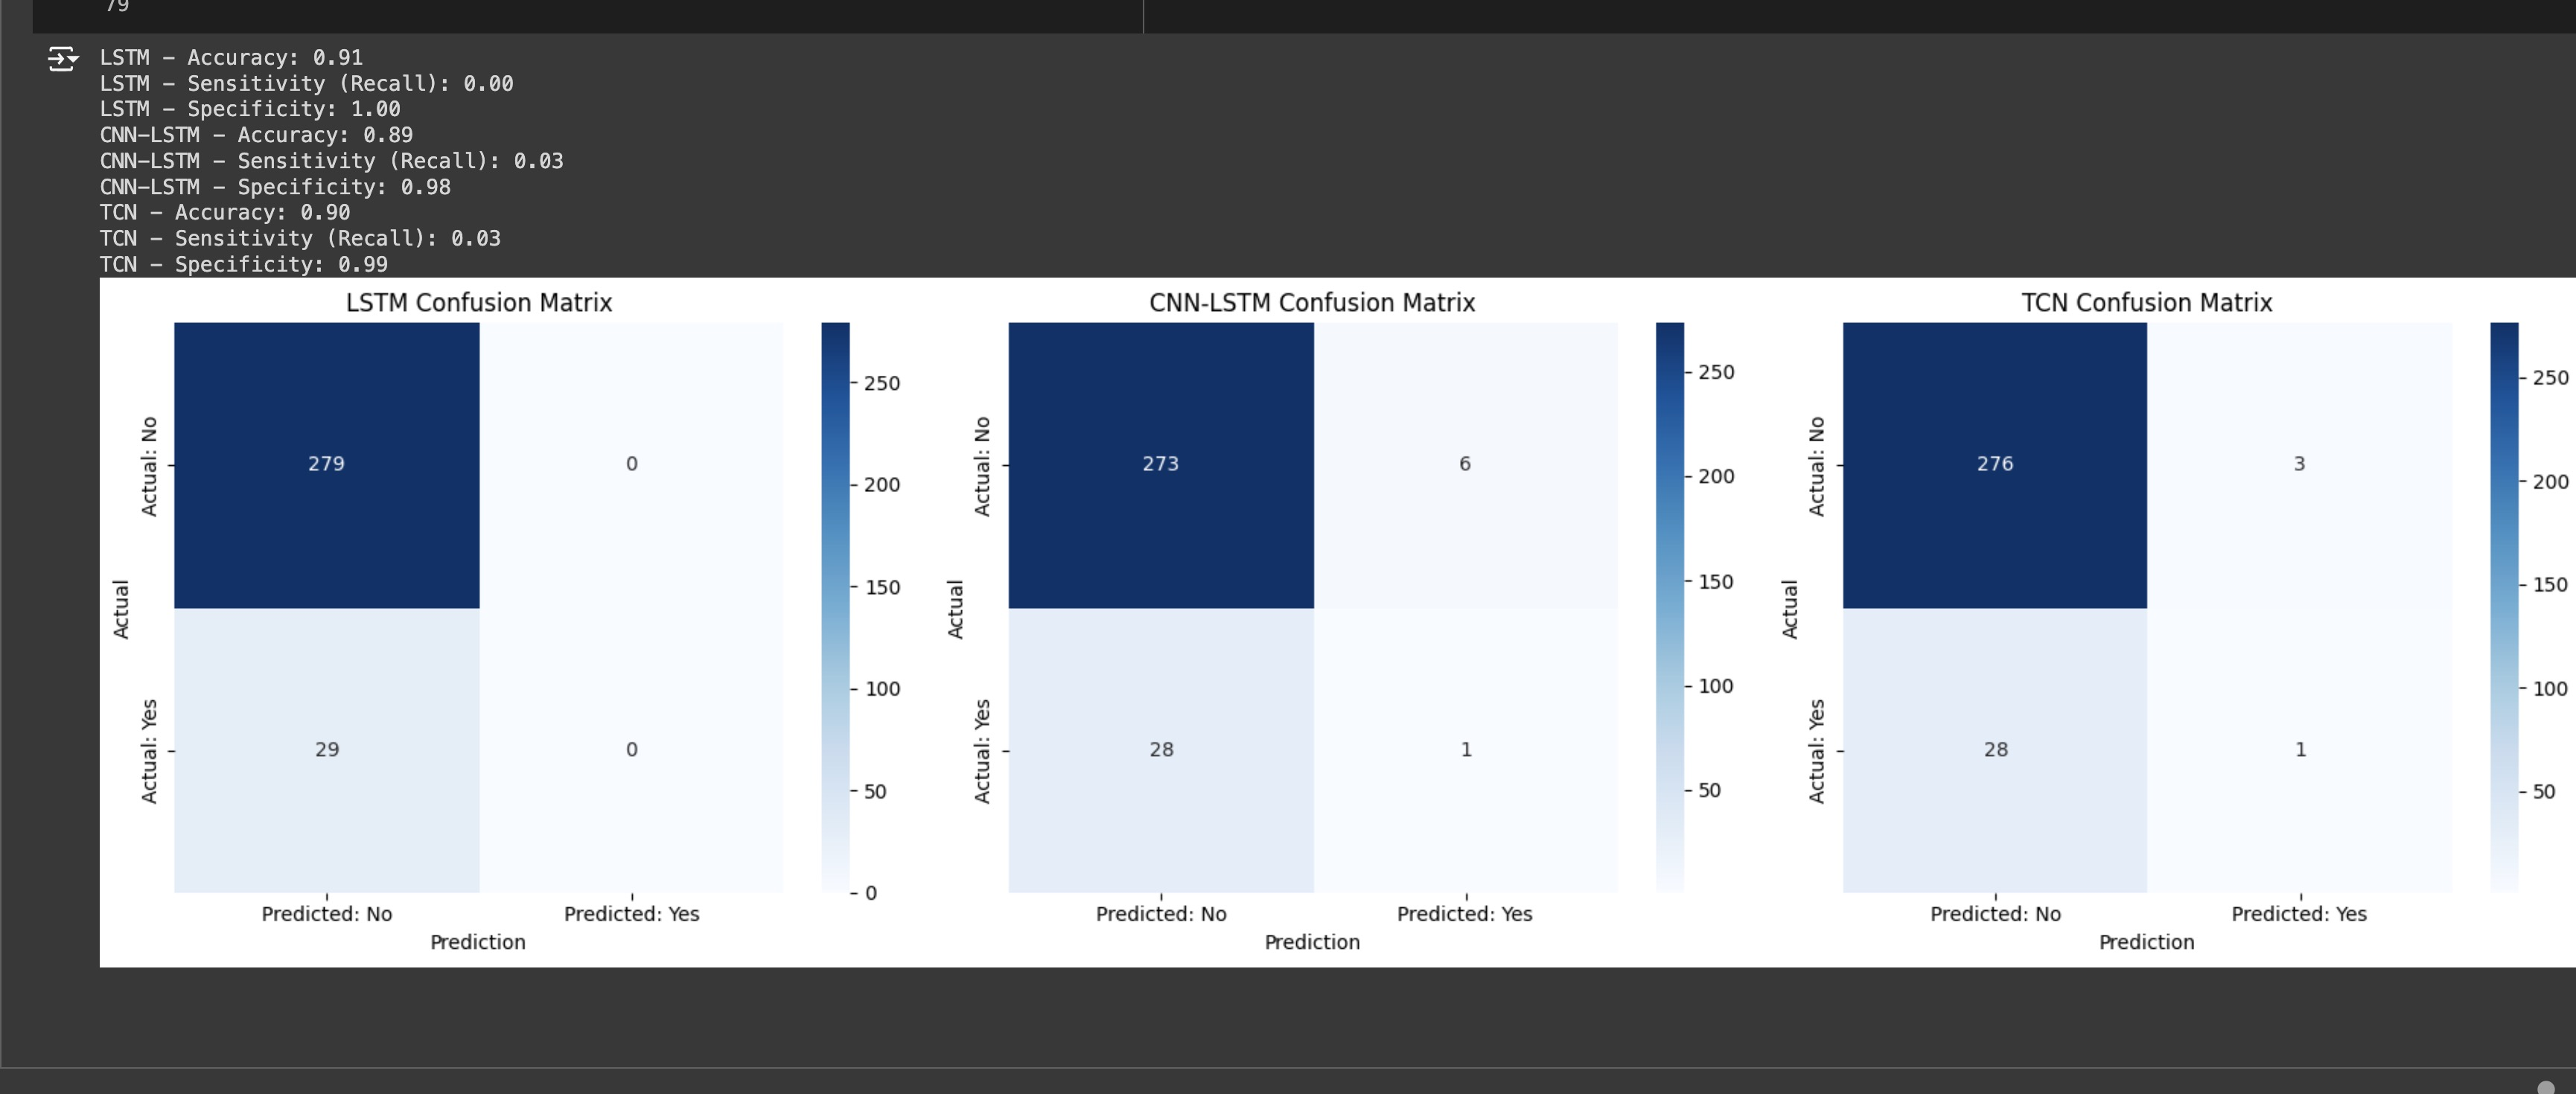


# 5.0 Evaluating Models (scaled data):

* This module is independend of the visualizations of the test predictions above. It can operate as soon as the models are all trained.

* With multivariate data mads_dl produces error for TCNs that I could not figure out yet

In [ ]:
try:
    results
except NameError:
    results = pd.DataFrame()

# Iterate over each entity ID
for entity_id, data in dataloaders.items():
    # Extract data from dataloaders
    train_loader = data['train_loader']
    test_loader = data['test_loader']
    scaler_X = data['scaler_X']
    scaler_y = data['scaler_y']

    # Prepare lists to accumulate data from the loaders
    X_train, y_train, X_test, y_test = [], [], [], []

    # Extract data from train_loader
    for X_batch, y_batch in train_loader:
        X_train.append(X_batch)
        y_train.append(y_batch)

    # Extract data from test_loader
    for X_batch, y_batch in test_loader:
        X_test.append(X_batch)
        y_test.append(y_batch)

    # Convert lists to tensors
    X_train = torch.cat(X_train).to(device)
    y_train = torch.cat(y_train).to(device)
    X_test = torch.cat(X_test).to(device)
    y_test = torch.cat(y_test).to(device)

    # Ensure models are set to evaluation mode
    models["per_entity"][entity_id]["LSTM"].eval()
    models["per_entity"][entity_id]["CNN_LSTM"].eval()
    models["per_entity"][entity_id]["TCN"].eval()

    # Make predictions for each model on this entity's dataset
    # LSTM predictions
    y_train_pred_lstm = mads_dl.predict(models["per_entity"][entity_id]["LSTM"], X_train)
    y_test_pred_lstm = mads_dl.predict(models["per_entity"][entity_id]["LSTM"], X_test)

    # CNN-LSTM predictions
    y_train_pred_lstmcnn = mads_dl.predict(models["per_entity"][entity_id]["CNN_LSTM"], X_train)
    y_test_pred_lstmcnn = mads_dl.predict(models["per_entity"][entity_id]["CNN_LSTM"], X_test)



    # Inverse transform the predictions and actual values
    y_train = scaler_y.inverse_transform(y_train.cpu().numpy().reshape(-1, 1))
    y_test = scaler_y.inverse_transform(y_test.cpu().numpy().reshape(-1, 1))
    y_train_pred_lstm = scaler_y.inverse_transform(y_train_pred_lstm.cpu().numpy().reshape(-1, 1))
    y_test_pred_lstm = scaler_y.inverse_transform(y_test_pred_lstm.cpu().numpy().reshape(-1, 1))
    y_train_pred_lstmcnn = scaler_y.inverse_transform(y_train_pred_lstmcnn.cpu().numpy().reshape(-1, 1))
    y_test_pred_lstmcnn = scaler_y.inverse_transform(y_test_pred_lstmcnn.cpu().numpy().reshape(-1, 1))
    #y_train_pred_tcn = scaler_y.inverse_transform(y_train_pred_tcn.cpu().numpy().reshape(-1, 1))
    #y_test_pred_tcn = scaler_y.inverse_transform(y_test_pred_tcn.cpu().numpy().reshape(-1, 1))

    # Store evaluation results for each model type
    results = mads_dl.add_regression_eval(
        results, f"LSTM_test_{entity_id}",
        y_train, y_train_pred_lstm,
        y_test, y_test_pred_lstm,
        mads_dl.count_params(models["per_entity"][entity_id]["LSTM"])
    )

    results = mads_dl.add_regression_eval(
        results, f"LSTM/CNN_test_{entity_id}",
        y_train, y_train_pred_lstmcnn,
        y_test, y_test_pred_lstmcnn,
        mads_dl.count_params(models["per_entity"][entity_id]["CNN_LSTM"])
    )



    # Combined models evaluation for the same entity data
    combined_models = models["combined"]
    combined_models["LSTM"].eval()
    combined_models["CNN_LSTM"].eval()
    combined_models["TCN"].eval()

    y_train_pred_combined_lstm = mads_dl.predict(combined_models["LSTM"], X_train)
    y_test_pred_combined_lstm = mads_dl.predict(combined_models["LSTM"], X_test)

    y_train_pred_combined_lstmcnn = mads_dl.predict(combined_models["CNN_LSTM"], X_train)
    y_test_pred_combined_lstmcnn = mads_dl.predict(combined_models["CNN_LSTM"], X_test)

    # Inverse transform combined models' predictions and actual values
    y_train_pred_combined_lstm = scaler_y.inverse_transform(y_train_pred_combined_lstm.cpu().numpy().reshape(-1, 1))
    y_test_pred_combined_lstm = scaler_y.inverse_transform(y_test_pred_combined_lstm.cpu().numpy().reshape(-1, 1))
    y_train_pred_combined_lstmcnn = scaler_y.inverse_transform(y_train_pred_combined_lstmcnn.cpu().numpy().reshape(-1, 1))
    y_test_pred_combined_lstmcnn = scaler_y.inverse_transform(y_test_pred_combined_lstmcnn.cpu().numpy().reshape(-1, 1))
    #y_train_pred_combined_tcn = scaler_y.inverse_transform(y_train_pred_combined_tcn.cpu().numpy().reshape(-1, 1))
    #y_test_pred_combined_tcn = scaler_y.inverse_transform(y_test_pred_combined_tcn.cpu().numpy().reshape(-1, 1))

    # Add combined models evaluation results for each entity
    results = mads_dl.add_regression_eval(
        results, f"Combined_LSTM_test_{entity_id}",
        y_train, y_train_pred_combined_lstm,
        y_test, y_test_pred_combined_lstm,
        mads_dl.count_params(combined_models["LSTM"])
    )

    results = mads_dl.add_regression_eval(
        results, f"Combined_LSTM/CNN_test_{entity_id}",
        y_train, y_train_pred_combined_lstmcnn,
        y_test, y_test_pred_combined_lstmcnn,
        mads_dl.count_params(combined_models["CNN_LSTM"])
    )


In [ ]:
results.head(72)

# 6.0 Save/Load models (inactive):

In [ ]:
#import os

# Define the model save path
model_save_path = f"KielRegionModelHBFDDORFAMA{str(lookback_lag)}{str(target_shift)}"

# Check if the directory exists, if not, create it
#if not os.path.exists(model_save_path):
#    os.makedirs(model_save_path)
#    print(f"Created directory: {model_save_path}")
#else:
#    print(f"Directory already exists: {model_save_path}")


In [ ]:
#import torch

# Save per-entity models
#for entity_id, entity_models in models["per_entity"].items():
#    for model_name, model in entity_models.items():
#        torch.save(model.state_dict(), f"{model_save_path}/{entity_id}_{model_name}.pth")
#        print(f"Saved model: {entity_id}_{model_name}.pth")

# Save combined models
#for model_name, model in models["combined"].items():
#    torch.save(model.state_dict(), f"{model_save_path}/combined_{model_name}.pth")
#    print(f"Saved model: combined_{model_name}.pth")


In [ ]:


# Initialize models dictionary
loaded_models = {
    "per_entity": {},
    "combined": {}
}

# Load per-entity models
#for entity_id in models["per_entity"].keys():
#    loaded_models["per_entity"][entity_id] = {}
#    for model_name in models["per_entity"][entity_id].keys():
#        model = models["per_entity"][entity_id][model_name]  # Retrieve the model structure
#        model.load_state_dict(torch.load(f"{model_save_path}/{entity_id}_{model_name}.pth"))
#        loaded_models["per_entity"][entity_id][model_name] = model
#        print(f"Loaded model: {entity_id}_{model_name}.pth")

# Load combined models
#for model_name in models["combined"].keys():
#    model = models["combined"][model_name]  # Retrieve the model structure
#    model.load_state_dict(torch.load(f"{model_save_path}/combined_{model_name}.pth"))
#    loaded_models["combined"][model_name] = model
#    print(f"Loaded model: combined_{model_name}.pth")

# 7.0 Testing on real world data (1.-14. October Test):

* need to update this for november and integrate october into training data
* Do we fit the scalers new or use the scaler from the training data?

### 7.1 Prepare Data for test (redo 1.0 but without training data):

In [ ]:
df2 = pd.read_csv('/content/drive/My Drive/Alter_Markt_Oktober.csv') # This is an example dataset just consisting of Alter Markt

df2.info()

In [2]:
### Example function for getting test data only, this fits new scaler (don't knwo if this is right)

def create_real_test_dataset_for_entity(df, entity_id, lookback_lag, target_shift):
    print(f"\nProcessing entity ID: {entity_id}")

    # Filter the DataFrame for the given entityId
    df_entity = df.loc[df['entityId'] == entity_id].reset_index(drop=True)
    print(f"Initial rows for entity {entity_id}: {len(df_entity)}")

    # Check if ID is valid
    if df_entity.empty:
        print(f"  Warning: No data found for entity {entity_id}. Skipping...")
        return None, None, None

    # Convert 'index' to datetime
    df_entity['index'] = pd.to_datetime(df_entity['index'])

    # Select relevant columns and create a copy to avoid SettingWithCopyWarning
    df_entity_model = df_entity[['index', 'availableBikeNumber', 'day_sin', 'day_cos', 'year_sin', 'year_cos']].copy()

    # Create targets (shifted values)
    df_entity_model['targets'] = df_entity_model['availableBikeNumber'].shift(target_shift - (lookback_lag + target_shift))

    # Drop rows with NaN values created by the shift
    df_entity_model.dropna(inplace=True)

    # Initialize scalers
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))

    # Convert DataFrame to numpy arrays
    data = df_entity_model[['availableBikeNumber', 'day_sin', 'day_cos', 'year_sin', 'year_cos']].to_numpy().astype(np.float32)
    targets = df_entity_model['targets'].to_numpy().astype(np.float32).reshape(-1, 1)

    # Fit scalers on the full dataset to use for test scaling only (for evaluation)
    scaler_X.fit(data)
    scaler_y.fit(targets)

    # Scale the data
    data_scaled = scaler_X.transform(data)
    targets_scaled = scaler_y.transform(targets)

    # Create sequences for X and y using sliding window
    X_sequences = []
    y_sequences = []

    # Iterate over the full dataset to generate test sequences only
    for i in range(len(data_scaled) - lookback_lag):
        X_sequences.append(data_scaled[i:i + lookback_lag])  # 48 time steps of 5 features
        y_sequences.append(targets_scaled[i])  # target for the sequence

    # Convert to numpy arrays
    X_sequences = np.array(X_sequences)
    y_sequences = np.array(y_sequences)

    print(f"  Feature dimension: {data.shape[1]}")
    print(f"  X_test shape: {X_sequences.shape}, y_test shape: {y_sequences.shape}")

    # Only return the test dataset
    return TimeSeriesDataset(X_sequences, y_sequences), scaler_X, scaler_y


### 7.2 Test models on data (redo 4. and 5.):